<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Classification/Residual_Attention_Network(2017).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('attention')

Mounted at attention


In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

# 1. 데이터셋 불러오기

In [ ]:
# specify path to data
path2data = '/content/attention/MyDrive/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [ ]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloade
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

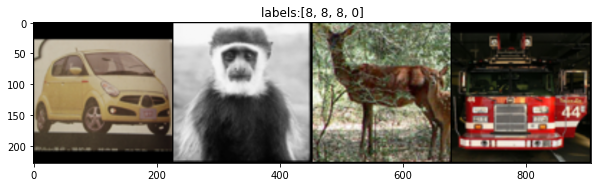

In [ ]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(15)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

# 2. 모델 구축하기
 코드 출처: https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/attention.py

In [ ]:
# Pre-Activation Residual Unit
class PreActResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        
        bottleneck_channels = int(out_channels / 4)

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, bottleneck_channels, 1, stride=stride, padding=0),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(),
            nn.Conv2d(bottleneck_channels, bottleneck_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(),
            nn.Conv2d(bottleneck_channels, out_channels, 1, stride=1, padding=0)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        return self.residual(x) + self.shortcut(x)


# AttentionModule 1
class AttentionModule1(nn.Module):
    def __init__(self, in_channels, out_channels, p=1, t=2, r=1):
        super().__init__()
        assert in_channels == out_channels

        self.pre = self._make_residual(in_channels, out_channels, p)
        self.trunk = self._make_residual(in_channels, out_channels, t)
        self.soft_resdown1 = self._make_residual(in_channels, out_channels, r) # 56x56 -> 28x28
        self.soft_resdown2 = self._make_residual(in_channels, out_channels, r) # 28x28 -> 14x14
        self.soft_resdown3 = self._make_residual(in_channels, out_channels, r) # 14x14 -> 7x7
        self.soft_resdown4 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 7x7
        self.soft_resup1 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 7x7
        self.soft_resup2 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 14x14
        self.soft_resup3 = self._make_residual(in_channels, out_channels, r) # 14x14 -> 28x28
        self.soft_resup4 = self._make_residual(in_channels, out_channels, r) # 28x28 -> 56x56

        self.shortcut_short = PreActResidual(in_channels, out_channels, 1)
        self.shortcut_long = PreActResidual(in_channels, out_channels, 1)

        self.sigmoid = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.Sigmoid()
        )

        self.last = self._make_residual(in_channels, out_channels, p)

    def forward(self, x):
        x = self.pre(x)
        input_size = (x.size(2), x.size(3))

        x_t = self.trunk(x)

        # first downsample out 28
        x_s = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x_s = self.soft_resdown1(x_s)

        # 28 shortcut
        shape1 = ((x_s.size(2), x_s.size(3)))
        shortcut_long = self.shortcut_long(x_s)

        # second downsample out 14
        x_s = F.max_pool2d(x_s, kernel_size=3, stride=2, padding=1)
        x_s = self.soft_resdown2(x_s)

        # 14 shortcut
        shape2 = ((x_s.size(2), x_s.size(3)))
        shortcut_short = self.shortcut_short(x_s)

        # third downsample out 7
        x_s = F.max_pool2d(x_s, kernel_size=3, stride=2, padding=1)
        x_s = self.soft_resdown3(x_s)

        # mid
        x_s = self.soft_resdown4(x_s)
        x_s = self.soft_resup1(x_s)

        # first upsample out 14
        x_s = self.soft_resup2(x_s)
        x_s = F.interpolate(x_s, size=shape2)
        x_s += shortcut_short

        # second upsample out 28
        x_s = self.soft_resup3(x_s)
        x_s = F.interpolate(x_s, size=shape1)
        x_s += shortcut_long

        # third upsample out 54
        x_s = self.soft_resup4(x_s)
        x_s = F.interpolate(x_s, size=input_size)

        x_s = self.sigmoid(x_s)
        x = (1+x_s) * x_t
        x = self.last(x)

        return x

    def _make_residual(self, in_channels, out_channels, p):
        layers = []
        for _ in range(p):
            layers.append(PreActResidual(in_channels, out_channels, 1))

        return nn.Sequential(*layers)


# AttentionModule 2
class AttentionModule2(nn.Module):
    def __init__(self, in_channels, out_channels, p=1, t=2, r=1):
        super().__init__()
        assert in_channels == out_channels

        self.pre = self._make_residual(in_channels, out_channels, p)
        self.trunk = self._make_residual(in_channels, out_channels, t)
        self.soft_resdown1 = self._make_residual(in_channels, out_channels, r) # 28x28 -> 14x14
        self.soft_resdown2 = self._make_residual(in_channels, out_channels, r) # 14x14 -> 7x7
        self.soft_resdown3 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 7x7
        self.soft_resup1 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 7x7
        self.soft_resup2 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 14x14
        self.soft_resup3 = self._make_residual(in_channels, out_channels, r) # 14x14 -> 28x28

        self.shortcut = PreActResidual(in_channels, out_channels, 1)

        self.sigmoid = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.Sigmoid()
        )

        self.last = self._make_residual(in_channels, out_channels, p)

    def forward(self, x):
        x = self.pre(x)
        input_size = (x.size(2), x.size(3))

        x_t = self.trunk(x)

        # first downsample out 14
        x_s = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x_s = self.soft_resdown1(x_s)

        # 14 shortcut
        shape1 = (x_s.size(2), x_s.size(3))
        shortcut = self.shortcut(x_s)

        # second downsample out 7
        x_s = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x_s = self.soft_resdown2(x_s)

        # mid
        x_s = self.soft_resdown3(x_s)
        x_s = self.soft_resup1(x_s)

        # first upsample out 14
        x_s = self.soft_resup2(x_s)
        x_s = nn.functional.interpolate(x_s, size=shape1)
        x_s += shortcut

        # second upsample out 28
        x_s = self.soft_resup3(x_s)
        x_s = nn.functional.interpolate(x_s, size=input_size)
        
        x_s = self.sigmoid(x_s)
        x = (1+x_s) * x_t
        x = self.last(x)
        return x

    def _make_residual(self, in_channels, out_channels, p):
        layers = []
        for _ in range(p):
            layers.append(PreActResidual(in_channels, out_channels, 1))

        return nn.Sequential(*layers)


# AttentionModule 3
class AttentionModule3(nn.Module):
    def __init__(self, in_channels, out_channels, p=1, t=2, r=1):
        super().__init__()

        self.pre = self._make_residual(in_channels, out_channels, p)
        self.trunk = self._make_residual(in_channels, out_channels, t)
        self.soft_resdown1 = self._make_residual(in_channels, out_channels, r) # 14x14 -> 7x7
        self.soft_resdown2 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 7x7
        self.soft_resup1 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 7x7
        self.soft_resup2 = self._make_residual(in_channels, out_channels, r) # 7x7 -> 14x14

        self.shortcut = PreActResidual(in_channels, out_channels, 1)

        self.sigmoid = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.Sigmoid()
        )

        self.last = self._make_residual(in_channels, out_channels, p)

    def forward(self, x):
        x = self.pre(x)
        input_size = (x.size(2), x.size(3))

        x_t = self.trunk(x)

        # first downsample out 7
        x_s = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x_s = self.soft_resdown1(x_s)

        # mid
        x_s = self.soft_resdown2(x_s)
        x_s = self.soft_resup1(x_s)

        # first upsample out 14
        x_s = self.soft_resup2(x_s)
        x_s = nn.functional.interpolate(x_s, size=input_size)

        x_s = self.sigmoid(x_s)
        x = (1+x_s) * x_t
        x = self.last(x)
        return x

    def _make_residual(self, in_channels, out_channels, p):
        layers = []
        for _ in range(p):
            layers.append(PreActResidual(in_channels, out_channels, 1))

        return nn.Sequential(*layers)


# Residual Attention Network
class AttentionNet(nn.Module):
    def __init__(self, nblocks, num_classes=10, init_weights=True):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.stage1 = self._make_stage(64, 256, nblocks[0], AttentionModule1, 1)
        self.stage2 = self._make_stage(256, 512, nblocks[1], AttentionModule2, 2)
        self.stage3 = self._make_stage(512, 1024, nblocks[2], AttentionModule3, 2)
        self.stage4 = nn.Sequential(
            PreActResidual(1024, 2048, 1),
            PreActResidual(2048, 2048, 1),
            PreActResidual(2048, 2048, 1)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_stage(self, in_channels, out_channels, nblock, block, stride):
        stage = []
        stage.append(PreActResidual(in_channels, out_channels, stride))

        for i in range(nblock):
            stage.append(block(out_channels, out_channels))

        return nn.Sequential(*stage)

def Attention50():
    return AttentionNet([1,1,1])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 224, 224)).to(device)
model = Attention50().to(device)
output = model(x)
print('output size:', output.size())

output size: torch.Size([3, 10])


In [ ]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]           4,160
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,640
           Conv2d-14          [-1, 256,

# 3. 학습하기

In [ ]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# define the training parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr= 0.01
Copied best model weights!
train loss: 334.021408, val loss: 4.610935, accuracy: 22.27, time: 2.7456 min
----------
Epoch 1/29, current lr= 0.01
train loss: 3.115021, val loss: 5.262319, accuracy: 24.77, time: 5.5632 min
----------
Epoch 2/29, current lr= 0.01
train loss: 2.413085, val loss: 6.301390, accuracy: 26.51, time: 8.4092 min
----------
Epoch 3/29, current lr= 0.01
Copied best model weights!
train loss: 2.243286, val loss: 2.572011, accuracy: 27.84, time: 11.2551 min
----------
Epoch 4/29, current lr= 0.01
Copied best model weights!
train loss: 2.065781, val loss: 2.544152, accuracy: 32.23, time: 14.0997 min
----------
Epoch 5/29, current lr= 0.01
train loss: 2.054436, val loss: 7.492126, accuracy: 27.32, time: 16.9471 min
----------
Epoch 6/29, current lr= 0.01
train loss: 2.064769, val loss: 4.902592, accuracy: 27.43, time: 19.7892 min
----------
Epoch 7/29, current lr= 0.01
train loss: 1.860609, val loss: 4.222343, accuracy: 33.15, time: 22.6278

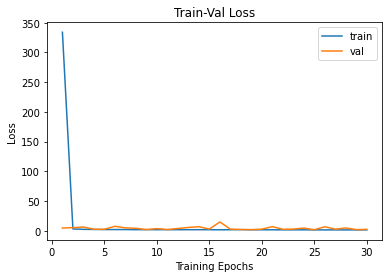

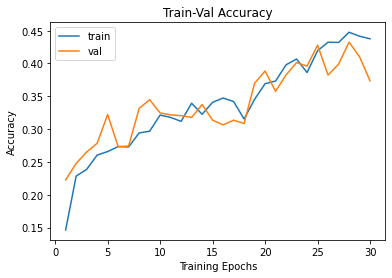

In [ ]:
# train-val progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()